In [671]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [743]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def p_active(w_ij, x_i, b, g):
    return sigmoid(g * (w_ij * x_i - b))

def step(x, w, b, g, t=0):
    p = p_active(w[t], x[t, t], b, g)
    x[t + 1, t + 1] =  (np.random.rand() < p).astype(int)
    
def run_activation(w, b, g):
    x = np.zeros((w.shape[0], w.shape[0])).astype(int)
    x[0, 0] = 1

    for t in range(w.shape[0] - 1):
        step(x, w, b, g, t)
    return x, w

def run_n_activations(w_0, b, g, n, w_transform=None, dropout_iter=1000, dropout_func=None):
    w = copy(w_0)
    X = []
    for i in range(n):
        if i == dropout_iter:
            w = dropout_func(w)
        x, w = run_activation(w, b, g)
        X.append(np.diag(x))
        if i > dropout_iter and w_transform is not None:
            w = w_transform(w, x)
    return np.array(X)

def w_transform_homeostatic(w, x):
    x_diag = np.diag(x)
    w[:-1] += 0.05 * (1 - x_diag[1:])
    return w

def w_transform_seq(w, x):
    x_diag = np.diag(x)
    w[:-1] += 0.1 * x_diag[:-1] * x_diag[1:]
    w = np.minimum(w, 15)
    return w

def make_dropout(p):
    def dropout(w):
        return np.random.binomial(100, 1-p, size=w.shape[0]) / 100 * w
    return dropout

def extract_lengths(X):
    l = np.zeros(X.shape[0])
    x_prod = np.ones(X.shape[0])
    for i in range(X.shape[1]):
        l += (X[:, i] * x_prod)
        x_prod *= X[:, i]
    return l

def extract_first_hitting_times(X_all_all, benchmark_lens):
    all_times = []
    for i_X, X in enumerate(X_all_all):
        times = np.nan * np.ones(len(benchmark_lens))
        counter = 0
        ls = extract_lengths(X)
        for j, l in enumerate(ls[20:]):

            if counter < len(times) and l >= benchmark_lens[counter]:
                while counter < len(times) and l >= benchmark_lens[counter]:
                    times[counter] = j
                    counter += 1
        all_times.append(times)
    return np.array(all_times)

def shave_front_zeros_except_last(arr):
    for i, x in enumerate(arr):
        if x != 0:
            if i == 0:
                return arr
            else:
                return arr[i-1:]
    return np.array([])
    

In [701]:
w_0 = 15 * np.ones(50)
b = 14
g = 2
X_all = run_n_activations(w_0, b, g, 100)

Text(0.5, 0, 'Rendition')

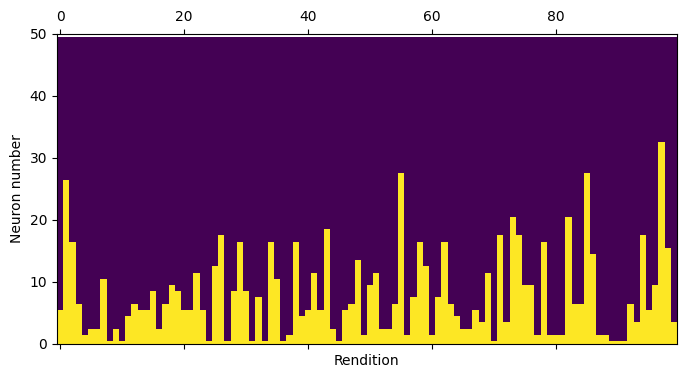

In [702]:
scale = 8
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
cbar = ax.matshow(X_all.T, vmax=1, vmin=0)
ax.set_ylim(0, X_all.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')

In [705]:
w_0 = 15 * np.ones(50)
b = 5
g = 2
X_all_all_parallel = []
for i in range(1):
    X_all = run_n_activations(w_0, b, g, 300, w_transform_homeostatic, dropout_iter=10, dropout_func=make_dropout(0.65))
    X_all_all_parallel.append(X_all)

Text(0.5, 0, 'Rendition')

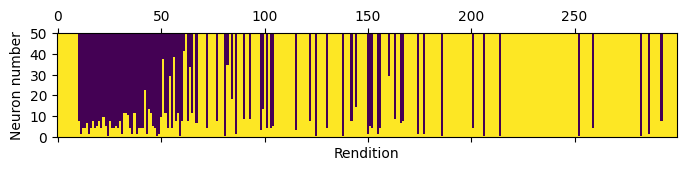

In [706]:
scale = 8
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
X = np.mean(X_all_all_parallel, axis=0)
cbar = ax.matshow(X.T, vmax=1, vmin=0)
ax.set_ylim(0, X.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')

In [711]:
w_0 = 15 * np.ones(50)
b = 5
g = 2
X_all_all_seq = []
for i in range(1):
    X_all = run_n_activations(w_0, b, g, 300, w_transform_seq, dropout_iter=10, dropout_func=make_dropout(0.65))
    X_all_all_seq.append(X_all)

Text(0.5, 0, 'Rendition')

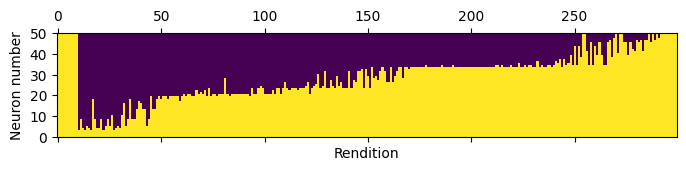

In [712]:
scale = 8
fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
X = np.mean(X_all_all_seq, axis=0)
cbar = ax.matshow(X.T, vmax=1, vmin=0)
ax.set_ylim(0, X.shape[1])
ax.set_ylabel('Neuron number')
ax.set_xlabel('Rendition')

In [715]:
w_0 = 15 * np.ones(50)
b = 5

X_across_dropouts = []

for dropout in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]: 
    X_all_all_parallel = []
    for i in range(100):
        X_all = run_n_activations(w_0, b, g, 300, w_transform_homeostatic, dropout_iter=10, dropout_func=make_dropout(dropout))
        X_all_all_parallel.append(X_all)

    X_all_all_seq = []
    for i in range(100):
        X_all = run_n_activations(w_0, b, g, 300, w_transform_seq, dropout_iter=10, dropout_func=make_dropout(dropout))
        X_all_all_seq.append(X_all)
    
    X_across_dropouts.append([X_all_all_parallel, X_all_all_seq])

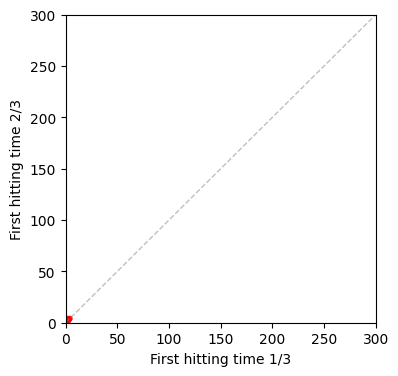

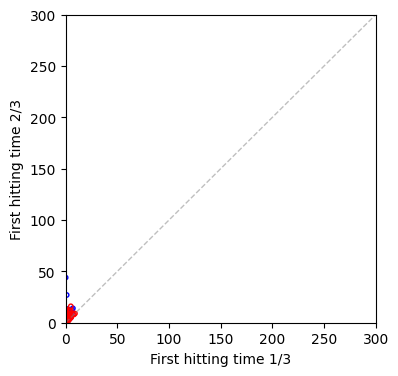

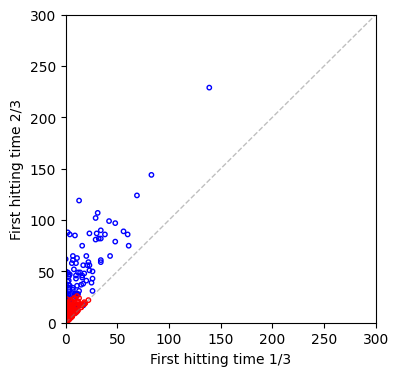

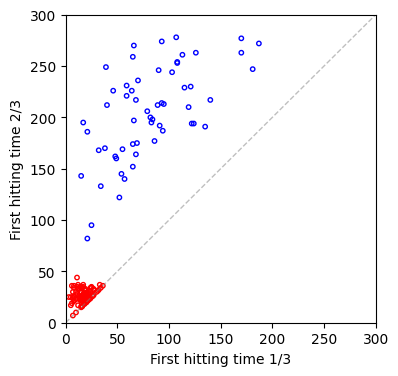

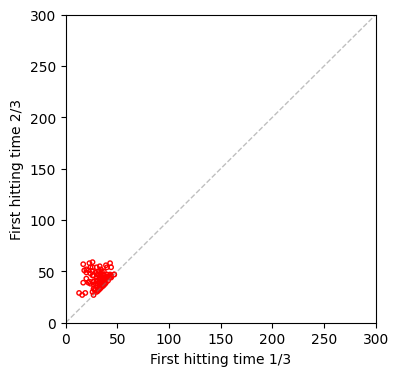

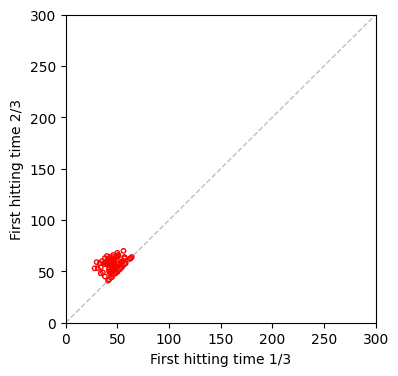

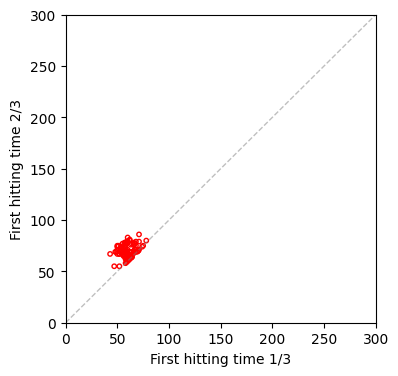

In [716]:
for dropout_i in range(len(X_across_dropouts)):
    
    X_all_all_parallel, X_all_all_seq = X_across_dropouts[dropout_i]
        
    hitting_times_seq = extract_first_hitting_times(X_all_all_seq, [18, 36])
    hitting_times_parallel = extract_first_hitting_times(X_all_all_parallel, [18, 36])
    
    scale = 4
    fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
    
    ax.plot(np.arange(300), np.arange(300), '--', lw=1, alpha=0.5, color='gray')

    ax.scatter(hitting_times_seq[:, 0], hitting_times_seq[:, 1], edgecolor='blue', facecolor='none', marker='o', s=10)
    ax.scatter(hitting_times_parallel[:, 0], hitting_times_parallel[:, 1], edgecolor='red', facecolor='none', marker='o', s=10)

    ax.set_xlabel('First hitting time 1/3')
    ax.set_ylabel('First hitting time 2/3')
    
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 300)
    

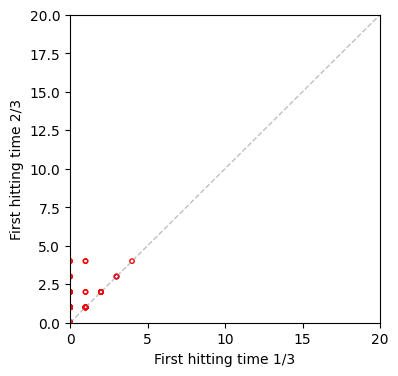

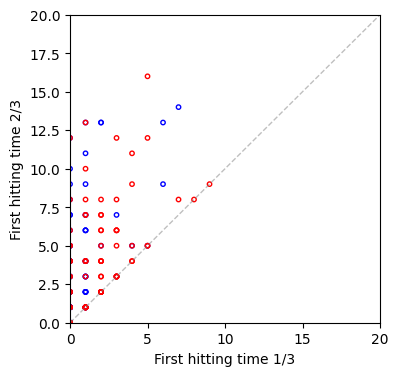

In [717]:
w_0 = 15 * np.ones(50)
b = 5

for dropout_i in range(2):
    
    X_all_all_parallel, X_all_all_seq = X_across_dropouts[dropout_i]
        
    hitting_times_seq = extract_first_hitting_times(X_all_all_seq, [18, 36])
    hitting_times_parallel = extract_first_hitting_times(X_all_all_parallel, [18, 36])
    
    scale = 4
    fig, ax = plt.subplots(1, figsize=(1 * scale, 1 * scale))
    
    ax.plot(np.arange(300), np.arange(300), '--', lw=1, alpha=0.5, color='gray')

    ax.scatter(hitting_times_seq[:, 0], hitting_times_seq[:, 1], edgecolor='blue', facecolor='none', marker='o', s=10)
    ax.scatter(hitting_times_parallel[:, 0], hitting_times_parallel[:, 1], edgecolor='red', facecolor='none', marker='o', s=10)

    ax.set_xlabel('First hitting time 1/3')
    ax.set_ylabel('First hitting time 2/3')
    
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    

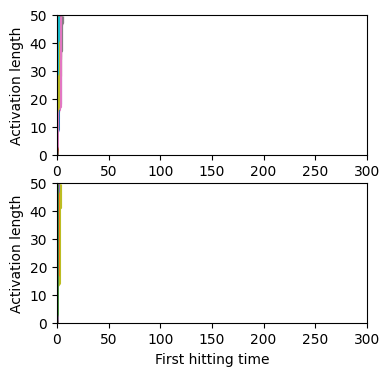

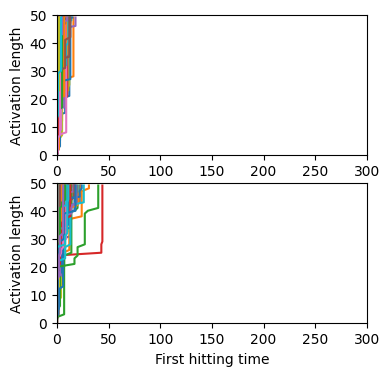

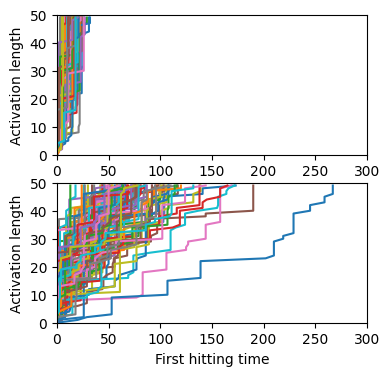

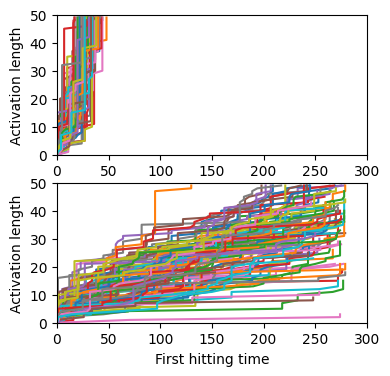

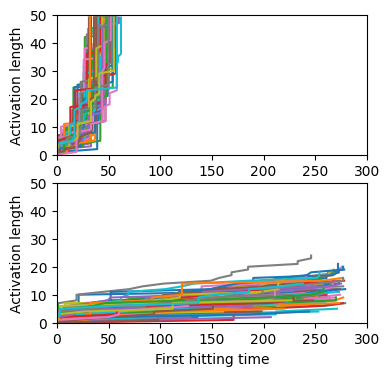

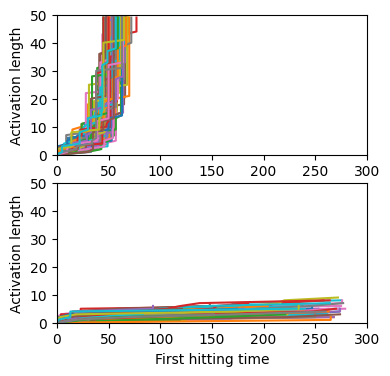

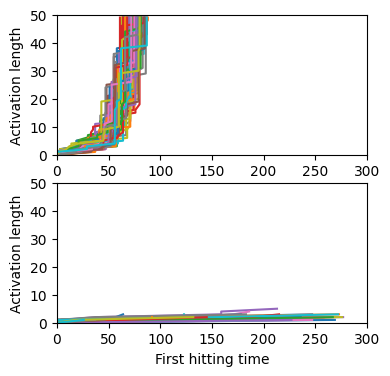

In [746]:
for dropout_i in range(len(X_across_dropouts)):
    
    X_all_all_parallel, X_all_all_seq = X_across_dropouts[dropout_i]
    
    hitting_times_parallel = extract_first_hitting_times(X_all_all_parallel, np.arange(1, 51))
    
    hitting_times_seq = extract_first_hitting_times(X_all_all_seq, np.arange(1, 51))
    
    scale = 4
    fig, axs = plt.subplots(2, figsize=(1 * scale, 1 * scale))
    
    for i in range(len(hitting_times_parallel)):
        axs[0].plot(hitting_times_parallel[i], np.arange(hitting_times_parallel.shape[1]))
        
    for i in range(len(hitting_times_seq)):
        axs[1].plot(hitting_times_seq[i], np.arange(hitting_times_seq.shape[1]))
#     ax.scatter(hitting_times_parallel[:, 0], hitting_times_parallel[:, 1], edgecolor='red', facecolor='none', marker='o', s=10)

#     ax.set_xlabel('First hitting time 1/3')
#     ax.set_ylabel('First hitting time 2/3')
    for j in range(2):
        axs[j].set_xlim(0, 300)
        axs[j].set_ylim(0, 50)
        axs[j].set_ylabel('Activation length')
        axs[j].set_xlabel('First hitting time')

In [721]:
r_squareds_parallel = []
r_squareds_seq = []

for dropout_i in range(len(X_across_dropouts)):
    
    X_all_all_parallel, X_all_all_seq = X_across_dropouts[dropout_i]
    
    hitting_times_parallel = extract_first_hitting_times(X_all_all_parallel, np.arange(1, 51))
    
    hitting_times_seq = extract_first_hitting_times(X_all_all_seq, np.arange(1, 51))
    
    r_values_parallel = []
    for i in range(len(hitting_times_parallel)):
        if (hitting_times_parallel[i] != 0).any() and hitting_times_parallel[i][-1] > 0:
            slope, intercept, r_value, p_value, std_err = linregress(hitting_times_parallel[i], np.arange(hitting_times_parallel.shape[1]))
            r_values_parallel.append(np.square(r_value))
     
    r_values_seq = []
    for i in range(len(hitting_times_seq)):
        if (hitting_times_seq[i] != 0).any() and hitting_times_seq[i][-1] > 0:
            slope, intercept, r_value, p_value, std_err = linregress(hitting_times_seq[i], np.arange(hitting_times_seq.shape[1]))
            r_values_seq.append(np.square(r_value))
            
    r_squareds_parallel.append(np.mean(r_values_parallel))
    r_squareds_seq.append(np.mean(r_values_seq))
#     ax.scatter(hitting_times_parallel[:, 0], hitting_times_parallel[:, 1], edgecolor='red', facecolor='none', marker='o', s=10)

#     ax.set_xlabel('First hitting time 1/3')
#     ax.set_ylabel('First hitting time 2/3')
    # for j in range(2):
    #     # axs[j].set_xlim(0, 300)
    #     axs[j].set_ylim(0, 50)
    #     axs[j].set_ylabel('Activation length')
    #     axs[j].set_xlabel('First hitting time')

Text(0.5, 0, 'Dropout percentage')

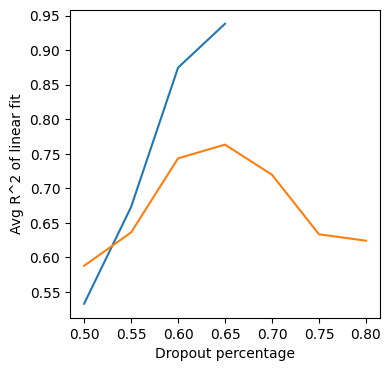

In [722]:
scale = 4
fig, axs = plt.subplots(1, figsize=(1 * scale, 1 * scale))

axs.plot([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8], r_squareds_seq)
axs.plot([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8], r_squareds_parallel)
[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
axs.set_ylabel('Avg R^2 of linear fit')
axs.set_xlabel('Dropout percentage')

In [1]:
for dropout_i in range(len(X_across_dropouts)):
    
    X_parallel, X_seq = X_across_dropouts[dropout_i]
    
    hitting_times_parallel = extract_first_hitting_times(X_parallel, np.arange(1, 51))
    
    hitting_times_seq = extract_first_hitting_times(X_seq, np.arange(1, 51))
    
    scale = 6
    fig, axs = plt.subplots(2, 2, figsize=(1 * scale, 1 * scale))
    
    seq_count = 0
    salt_count = 0
    
    for i in range(len(hitting_times_parallel)):
        cropped_hitting_time = shave_front_zeros_except_last(hitting_times_parallel[i])
        
        if cropped_hitting_time.shape[0] > 0 and cropped_hitting_time[-1] > 0 and (cropped_hitting_time != cropped_hitting_time[0]).any():
            activation_lengths = np.arange(51 - cropped_hitting_time.shape[0], 51)
            slope, intercept, r_value, p_value, std_err = linregress(activation_lengths, cropped_hitting_time)
            if np.square(r_value) > 0.9:  
                axs[0, 1].plot(cropped_hitting_time, activation_lengths)
                seq_count += 1
            else:
                axs[0, 0].plot(cropped_hitting_time, activation_lengths)
                salt_count += 1
                
    axs[0, 0].set_title(f'Homeostatic, saltatory {salt_count} of {seq_count + salt_count}')
    axs[0, 1].set_title(f'Homeostatic, sequential {seq_count} of {seq_count + salt_count}')
         
    seq_count = 0
    salt_count = 0
    
    for i in range(len(hitting_times_seq)):
        cropped_hitting_time = shave_front_zeros_except_last(hitting_times_seq[i])

        if cropped_hitting_time.shape[0] > 0 and cropped_hitting_time[-1] > 0 and (cropped_hitting_time != cropped_hitting_time[0]).any():
            activation_lengths = np.arange(51 - cropped_hitting_time.shape[0], 51)
            slope, intercept, r_value, p_value, std_err = linregress(activation_lengths, cropped_hitting_time)
            if np.square(r_value) > 0.9:  
                axs[1, 1].plot(cropped_hitting_time, activation_lengths)
                seq_count += 1
            else:
                axs[1, 0].plot(cropped_hitting_time, activation_lengths)
                salt_count += 1
                
    axs[1, 0].set_title(f'STDP, saltatory {salt_count} of {seq_count + salt_count}')
    axs[1, 1].set_title(f'STDP, sequential {seq_count} of {seq_count + salt_count}')

    for j in range(2):
        for k in range(2):
            axs[j, k].set_ylim(0, 50)
            if dropout_i < 3:
                axs[j, k].set_xlim(0, 50)
            else:
                axs[j, k].set_xlim(0, 300)
            axs[j, k].set_ylabel('Activation length')
            axs[j, k].set_xlabel('First hitting time')
            
    fig.tight_layout()

NameError: name 'X_across_dropouts' is not defined